# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [15]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [16]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [17]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y):
        self.model.fit(self.xgb_adapter(data_x), data_y)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
        
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [18]:
def cross_validation_normal(data_x, data_y, model, folds):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
            
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)

def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
        
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)
    
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        if(ratio_negatives_to_positives >= 1):            
            results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
        else:
            results = cross_validation_normal(data_x, data_y, models[model], folds)    
            
        display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1"]))
        print("")

In [19]:
models ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(), 
    "KNN" : KNeighborsClassifier(weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [20]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 2.8 MB


In [21]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.504682,0.082105,0.532217,0.927182,0.142128
Validation,0.499585,0.080201,0.492180,0.919672,0.137246



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.512274,0.834798,0.508134,0.189818,0.605411
Validation,0.502459,0.835386,0.503825,0.168852,0.604890



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.517001,0.807072,0.515508,0.227000,0.600859
Validation,0.500386,0.784580,0.476687,0.215574,0.579959



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.516865,0.661980,0.536472,0.371818,0.508454
Validation,0.496295,0.632967,0.469513,0.359016,0.479868



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.507955,0.022005,0.787647,0.993818,0.042689
Validation,0.502862,0.018792,0.527778,0.987705,0.035980



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.513455,0.481919,0.549085,0.544909,0.394456
Validation,0.497951,0.449080,0.479140,0.547541,0.366326


In [22]:

comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.527593,0.202580,0.579734,0.852545,0.299634
Validation,0.520020,0.199494,0.543921,0.840984,0.287440



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.537867,0.732794,0.536505,0.343000,0.585245
Validation,0.527012,0.713321,0.511745,0.340164,0.564331



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.543503,0.738799,0.544579,0.348273,0.589179
Validation,0.525375,0.706744,0.515012,0.343443,0.562616



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.542913,0.736703,0.544263,0.349182,0.587671
Validation,0.527014,0.708437,0.519274,0.345082,0.565016



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.512865,0.031733,0.841848,0.993909,0.061109
Validation,0.508187,0.029435,0.652857,0.987705,0.056058



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.540868,0.659555,0.545472,0.422182,0.552628
Validation,0.533575,0.642556,0.535661,0.424590,0.538948


We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [23]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [24]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

,sys,dia,age
5135,195.0,135.0,4
6106,215.0,115.0,4
9058,200.0,120.0,3
11792,190.0,130.0,3
14314,205.0,125.0,4
19137,215.0,117.0,4
20168,190.0,130.0,4
20379,220.0,140.0,4
20582,200.0,118.0,4
28579,180.0,130.0,3


As expected, all pressure variables (including pam) are correlated between each other

In [25]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

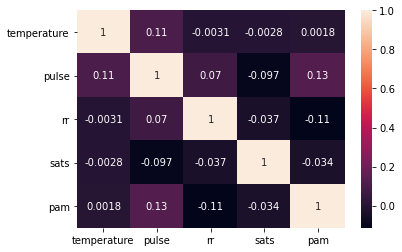

In [26]:
sns.heatmap(vitals.corr(), annot=True)

In [27]:
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.566925,0.530484,0.571946,0.603333,0.550428
Validation,0.559166,0.531418,0.562963,0.587156,0.545634



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661968,0.611869,0.680311,0.712020,0.643905
Validation,0.589785,0.538716,0.603335,0.641284,0.564707



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998080,0.997877,0.998282,0.998283,0.998079
Validation,0.544081,0.536864,0.544936,0.551376,0.540116



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.571472,0.633606,0.563564,0.509394,0.596249
Validation,0.576061,0.636097,0.568689,0.515596,0.599555



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998888,0.997776,1.000000,1.000000,0.998887
Validation,0.540884,0.534112,0.542631,0.547706,0.537578



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.586884,0.555354,0.592685,0.618384,0.573374
Validation,0.571034,0.546881,0.575052,0.595413,0.557742


In [28]:
vitals_ex = pd.merge(vitals, e_factors, left_index=True, right_index=True)
run_models(vitals_ex, y[vitals_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570967,0.537356,0.575870,0.604545,0.555904
Validation,0.580168,0.531384,0.590678,0.629358,0.558617



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661058,0.637551,0.668958,0.684545,0.652751
Validation,0.573769,0.570525,0.574151,0.577064,0.570373



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999697,0.999596,0.999798,0.999798,0.999697
Validation,0.569689,0.569675,0.571455,0.569725,0.570301



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.571067,0.582554,0.569604,0.559596,0.575570
Validation,0.569660,0.588707,0.567223,0.550459,0.575425



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999949,0.999899,1.000000,1.000000,0.999949
Validation,0.531287,0.521351,0.534397,0.541284,0.527105



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.591279,0.569509,0.595279,0.613030,0.58208
Validation,0.581088,0.551376,0.585605,0.611009,0.56626


In [29]:
vitals_comorb = pd.merge(vitals, comorb, left_index=True, right_index=True)
run_models(vitals_comorb, y[vitals_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.564803,0.536548,0.568520,0.593030,0.552043
Validation,0.565104,0.531401,0.570782,0.599083,0.548770



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.639937,0.603678,0.651498,0.676162,0.626078
Validation,0.589783,0.541443,0.601079,0.638532,0.566190



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998686,0.998585,0.998788,0.998788,0.998685
Validation,0.555042,0.527773,0.560850,0.582569,0.543176



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.571775,0.549590,0.575355,0.593939,0.561466
Validation,0.562379,0.550575,0.564399,0.574312,0.554867



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999090,0.998180,1.000000,1.000000,0.999089
Validation,0.544535,0.546839,0.546065,0.542202,0.545779



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.582739,0.557173,0.587022,0.608283,0.571671
Validation,0.569689,0.550542,0.570893,0.588991,0.558560


In [50]:
vitals_comorb_ex = pd.merge(vitals_comorb, e_factors, left_index=True, right_index=True)
run_models(vitals_comorb_ex, y[vitals_comorb_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.579152,0.544333,0.584957,0.613939,0.563867
Validation,0.562815,0.532302,0.567498,0.593578,0.547759



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.651206,0.618947,0.662295,0.683434,0.639367
Validation,0.584295,0.546947,0.590095,0.622018,0.564318



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999899,1.000000,0.999798,0.999798,0.999899
Validation,0.560069,0.544979,0.561353,0.575229,0.551792



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.567025,0.549385,0.569552,0.584646,0.558695
Validation,0.563751,0.536939,0.566418,0.590826,0.548766



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999596,0.999191,1.000000,1.000000,0.999595
Validation,0.521694,0.525988,0.522944,0.517431,0.523409



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.592996,0.574056,0.596532,0.611919,0.585030
Validation,0.586111,0.557756,0.590395,0.614679,0.571739


### Assesed Symptoms

In [31]:
a_symptoms.dropna(how="all", inplace=True)

In [32]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.543697,0.848653,0.527117,0.238827,0.650303
Validation,0.536263,0.847311,0.522513,0.224370,0.646051



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.594497,0.401603,0.653855,0.787337,0.497520
Validation,0.603861,0.397332,0.674483,0.810924,0.498591



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.602505,0.401045,0.672104,0.803911,0.502012
Validation,0.574530,0.379762,0.623986,0.769748,0.470605



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.550541,0.603992,0.576060,0.497114,0.531680
Validation,0.543418,0.601758,0.557076,0.484874,0.518981



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.585370,0.339664,0.668211,0.831006,0.448268
Validation,0.566954,0.305217,0.641703,0.829412,0.409564



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.542533,0.823593,0.52705,0.261546,0.642655
Validation,0.526639,0.815616,0.51746,0.236975,0.632987


In [33]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.551054,0.718441,0.537827,0.383706,0.612858
Validation,0.537515,0.714125,0.528696,0.360504,0.605422



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.601992,0.600705,0.604720,0.603259,0.599244
Validation,0.600496,0.577675,0.609124,0.623529,0.588476



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.645714,0.585738,0.669471,0.705680,0.620885
Validation,0.568617,0.509503,0.581961,0.627731,0.539751



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.569585,0.615059,0.574351,0.524115,0.575341
Validation,0.548861,0.588375,0.552417,0.509244,0.547325



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.628346,0.365460,0.771415,0.891155,0.495466
Validation,0.561501,0.300161,0.629449,0.823529,0.402938



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570378,0.709239,0.555162,0.431564,0.62204
Validation,0.559356,0.687178,0.547096,0.431092,0.60796


In [34]:
a_symptoms_comorb = pd.merge(a_symptoms, comorb, left_index=True, right_index=True)
run_models(a_symptoms_comorb, y[a_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.546723,0.752307,0.535332,0.341155,0.603478
Validation,0.548868,0.737052,0.539984,0.360504,0.598735



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.590446,0.420231,0.637969,0.760615,0.506140
Validation,0.584579,0.408228,0.630587,0.761345,0.493367



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.624110,0.427492,0.705006,0.820670,0.531894
Validation,0.585391,0.380595,0.647667,0.790756,0.476339



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.557108,0.654192,0.575487,0.460056,0.559177
Validation,0.535435,0.637759,0.560324,0.432773,0.544875



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.603110,0.334077,0.729030,0.872067,0.452302
Validation,0.553922,0.273235,0.597719,0.835294,0.370668



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.548307,0.771535,0.533514,0.325140,0.630540
Validation,0.526193,0.744244,0.518994,0.307563,0.611072


In [35]:
a_symptoms_comorb_ef = pd.merge(a_symptoms, comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef, y[a_symptoms_comorb_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.562368,0.735180,0.546679,0.389572,0.617858
Validation,0.550571,0.711036,0.535329,0.389916,0.602269



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.593333,0.485414,0.624559,0.701210,0.53940
Validation,0.576968,0.451821,0.608633,0.702521,0.51304



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.642780,0.494359,0.703605,0.791155,0.580144
Validation,0.561881,0.417493,0.589050,0.706723,0.487682



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570004,0.714988,0.56608,0.425047,0.612218
Validation,0.540484,0.673964,0.54598,0.406723,0.580175



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.612049,0.328578,0.760868,0.895438,0.457230
Validation,0.563987,0.280784,0.644444,0.847899,0.387706



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570097,0.749084,0.551592,0.391155,0.635226
Validation,0.574909,0.732563,0.556423,0.416807,0.631936


In [36]:
a_symptoms_comorb_ef_vitals = pd.merge(vitals, a_symptoms_comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef_vitals, y[a_symptoms_comorb_ef_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.582500,0.629930,0.575713,0.535091,0.600968
Validation,0.580334,0.620067,0.575306,0.540367,0.595609



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.667816,0.634099,0.679968,0.701521,0.656064
Validation,0.623746,0.582410,0.633916,0.665138,0.604619



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999594,0.999290,0.999898,0.999899,0.999594
Validation,0.581199,0.556847,0.584251,0.605505,0.568628



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572306,0.560940,0.573759,0.583671,0.566939
Validation,0.579831,0.547815,0.585632,0.611927,0.564515



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999899,0.999797,1.000000,1.000000,0.999898
Validation,0.524503,0.497698,0.527377,0.551376,0.511496



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.603752,0.596850,0.605145,0.610649,0.600839
Validation,0.585746,0.594304,0.582917,0.577064,0.586662


### Reported symptoms

In [37]:
r_symptoms

,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,True,3.0,NaN,False,0.0,False,False,False,False,False,False,False,False
1,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
2,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2.0,False,True,2.0,False,True,False,False,False,False,False,True
4,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False
93990,True,2.0,False,False,0.0,False,False,False,False,False,True,False,True
93991,False,0.0,True,False,0.0,False,False,False,False,False,False,False,False
93993,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False


In [38]:
r_symptoms.dropna(how="all", inplace=True)

In [39]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.630693,0.366338,0.777307,0.895000,0.497822
Validation,0.627339,0.364881,0.768487,0.890164,0.490957



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.660832,0.492361,0.743012,0.829273,0.591982
Validation,0.662145,0.489291,0.749548,0.835246,0.585921



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.705200,0.514183,0.832050,0.896182,0.635505
Validation,0.642084,0.439398,0.737179,0.845082,0.548364



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.681698,0.499635,0.786217,0.863727,0.610633
Validation,0.646176,0.459856,0.732048,0.832787,0.561607



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.692108,0.441804,0.885591,0.942364,0.588544
Validation,0.617104,0.367386,0.736653,0.867213,0.487446



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.663923,0.495552,0.749682,0.832273,0.595623
Validation,0.658063,0.480255,0.744959,0.836066,0.578941


In [40]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.623375,0.341789,0.782521,0.904909,0.475617
Validation,0.618314,0.332953,0.770332,0.904098,0.462290



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.659969,0.508728,0.729372,0.811182,0.599326
Validation,0.649450,0.502386,0.706511,0.796721,0.583919



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.703291,0.500181,0.842754,0.906364,0.627467
Validation,0.647799,0.445868,0.746918,0.850000,0.554758



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.686471,0.507544,0.790537,0.865364,0.618028
Validation,0.649436,0.475363,0.724752,0.823770,0.571457



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.693653,0.440894,0.892540,0.946364,0.589349
Validation,0.620381,0.355158,0.758285,0.886066,0.483248



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662787,0.47854,0.757717,0.847000,0.586500
Validation,0.648613,0.46716,0.729197,0.830328,0.565938


In [41]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.614056,0.322240,0.773314,0.905818,0.454625
Validation,0.601954,0.310036,0.746621,0.894262,0.433758



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.659969,0.506092,0.731564,0.813818,0.598006
Validation,0.660515,0.502386,0.730977,0.818852,0.592636



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.697290,0.505001,0.820799,0.889545,0.625130
Validation,0.637556,0.440164,0.725073,0.835246,0.544291



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.684790,0.506730,0.787442,0.862818,0.616359
Validation,0.653546,0.481074,0.731427,0.826230,0.577556



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.686790,0.440171,0.870839,0.933364,0.583358
Validation,0.633478,0.382094,0.769576,0.885246,0.508491



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.664287,0.488725,0.753428,0.839818,0.592767
Validation,0.655161,0.490084,0.730558,0.820492,0.582450


In [48]:
ra_symptoms = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms, left_index=True, right_index=True)
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.643712,0.496415,0.703721,0.790968,0.582106
Validation,0.645422,0.493789,0.705433,0.797479,0.577609



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.670811,0.536463,0.733588,0.805121,0.619630
Validation,0.663445,0.528943,0.721762,0.798319,0.606655



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.763282,0.589270,0.903752,0.937244,0.713334
Validation,0.639571,0.460259,0.718727,0.819328,0.559204



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.657960,0.450405,0.770228,0.865456,0.567990
Validation,0.649184,0.440938,0.753807,0.857983,0.553236



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.755646,0.545219,0.941479,0.966015,0.690326
Validation,0.636595,0.417458,0.742945,0.856303,0.532895



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.673279,0.499396,0.765753,0.847114,0.604470
Validation,0.652542,0.489538,0.721540,0.815966,0.580352


In [43]:
r_symptoms_ex = pd.merge(r_symptoms.drop(columns=["sob", "cough"]), e_factors, left_index=True, right_index=True)
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.642104,0.467359,0.718327,0.816818,0.566205
Validation,0.639227,0.462342,0.717279,0.816393,0.558780



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.665378,0.510457,0.739723,0.820273,0.60394
Validation,0.653958,0.504012,0.714387,0.804098,0.58826



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.750750,0.572647,0.889657,0.928818,0.696671
Validation,0.643302,0.468812,0.720231,0.818033,0.564882



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.675334,0.488270,0.780145,0.862364,0.600369
Validation,0.644545,0.459863,0.727537,0.829508,0.560500



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.747113,0.523729,0.946655,0.970455,0.674241
Validation,0.615055,0.380481,0.715660,0.850000,0.494861



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662242,0.499913,0.742309,0.824545,0.596657
Validation,0.646198,0.471285,0.726124,0.821311,0.566753


In [51]:
r_symptoms_vitals = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), vitals, left_index=True, right_index=True)
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.658835,0.516430,0.721950,0.801111,0.601973
Validation,0.661026,0.517765,0.725435,0.805505,0.602441



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.689152,0.581035,0.741329,0.797172,0.651277
Validation,0.666072,0.557781,0.712860,0.775229,0.623460



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999293,0.999090,0.999495,0.999495,0.999292
Validation,0.620387,0.580525,0.632157,0.660550,0.604495



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.577081,0.546058,0.581925,0.608081,0.563064
Validation,0.571505,0.535938,0.578458,0.607339,0.554910



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999495,0.998989,1.000000,1.000000,0.999494
Validation,0.543167,0.468590,0.552957,0.618349,0.507041



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.672831,0.544840,0.732300,0.800707,0.624592
Validation,0.656914,0.519583,0.717245,0.795413,0.601423


In [53]:
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.651230,0.531201,0.698823,0.771197,0.603520
Validation,0.661788,0.519608,0.726714,0.804587,0.604405



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.693482,0.599287,0.738395,0.787627,0.661521
Validation,0.667297,0.571660,0.706568,0.763303,0.630038



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999696,0.999493,0.999898,0.999899,0.999695
Validation,0.624285,0.596389,0.632812,0.652294,0.613461



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.574588,0.549376,0.578722,0.599797,0.563209
Validation,0.568414,0.542335,0.571480,0.594495,0.555480



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999797,0.999594,1.000000,1.000000,0.999797
Validation,0.567092,0.484103,0.581787,0.650459,0.527771



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.681967,0.559102,0.741420,0.804767,0.637251
Validation,0.677376,0.536130,0.746335,0.819266,0.622551


In [45]:
r_symptoms_comorb = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), comorb, left_index=True, right_index=True)
run_models(r_symptoms_comorb, y[r_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.635830,0.396437,0.760645,0.875182,0.520978
Validation,0.630199,0.396788,0.744530,0.863934,0.514193



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.659378,0.509274,0.727925,0.809455,0.599185
Validation,0.655994,0.505658,0.720594,0.806557,0.589200



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.716111,0.521367,0.854402,0.910818,0.647219
Validation,0.652737,0.448414,0.759185,0.857377,0.561970



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.696517,0.516909,0.807358,0.876091,0.629833
Validation,0.644547,0.475410,0.717187,0.813934,0.568580



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.709383,0.472992,0.897542,0.945727,0.619100
Validation,0.628983,0.380521,0.756912,0.877869,0.504798



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.664651,0.486816,0.755557,0.842455,0.592018
Validation,0.658468,0.477836,0.745391,0.839344,0.580267


In [49]:
all_data = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms_comorb_ef_vitals, left_index=True, right_index=True)
run_models(all_data, y[all_data.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.659295,0.537389,0.710678,0.781136,0.611876
Validation,0.661309,0.535113,0.716918,0.788073,0.612020



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.693279,0.605072,0.734703,0.781440,0.663401
Validation,0.663615,0.574370,0.698633,0.753211,0.629432



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999848,0.999898,0.999797,0.999797,0.999848
Validation,0.620131,0.597189,0.626928,0.643119,0.610225



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572711,0.545409,0.577170,0.600000,0.560479
Validation,0.564773,0.546080,0.567178,0.583486,0.554280



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999848,0.999696,1.00000,1.000000,0.999848
Validation,0.557450,0.487731,0.56828,0.627523,0.524564



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.684706,0.588128,0.728942,0.781237,0.650945
Validation,0.664553,0.564337,0.706558,0.765138,0.626126


In [ ]:
a = pd.Series(np.array([True, False, True, False]))
b = pd.Series(np.array([True, True, False, False]))

In [ ]:
(a ^ b)

Next step is to determine which features are useful in the case of each dataset, eliminating them one by one(and maybe applying normalization to the vitals).
After that, we select the 2 (first just 2) best models and somehow combine them to make an ensemble model.<br>
<i>Idea: One model for each metric so 4 models with the highest metrics and then figure out some boolean operation to combine them</i><br>
<i>Idea 2: The boolean operation can be found by using a Decision Tree. After all they are good at finding simple rules</i><br>
<i>Idea 3: The boolean operation taking the highest precision and the highest recall would be an AND. Maybe the inverse for another 2 metrics as well</i>